In [1]:
import json, os, pickle, random
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn

import qiskit
from qiskit import QuantumCircuit, execute
from qiskit.compiler import transpile
from qiskit_aer import AerSimulator, QasmSimulator
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.quantum_info import SparsePauliOp, Operator
from qiskit.circuit.library import CXGate, RXGate, IGate, ZGate
from qiskit.providers.fake_provider import FakeMontreal, FakeLima, FakeSherbrooke

from blackwater.data.utils import (
    generate_random_pauli_sum_op,
    create_estimator_meas_data,
    circuit_to_graph_data_json,
    get_backend_properties_v1,
    encode_pauli_sum_op,
    create_meas_data_from_estimators
)

from mbd_utils import cal_z_exp, generate_disorder, construct_mbl_circuit, calc_imbalance, modify_and_add_noise_to_model

import matplotlib.pyplot as plt
import seaborn as sns
from noise_utils import AddNoise

import importlib
import mlp
importlib.reload(mlp)
from mlp import MLP1, MLP2, MLP3, encode_data, encode_data_v2_ecr

In [2]:
from qiskit_ibm_provider import IBMProvider
provider = IBMProvider()

In [3]:
real_backend = provider.get_backend('ibm_brisbane')

In [4]:
fake_backend = FakeSherbrooke()

## Local
fake_backend_ideal = QasmSimulator() # Noiseless
fake_backend_noisy = AerSimulator.from_backend(fake_backend) # Noisy
stabilizer_simulator = AerSimulator(method='stabilizer')

fake_run_config_ideal = {'shots': 10000, 'backend': fake_backend_ideal, 'name': 'fake_ideal'}
fake_run_config_noisy = {'shots': 10000, 'backend': fake_backend_noisy, 'name': 'fake_noisy'}

In [5]:
import os
from tqdm.notebook import tqdm

def check_f(f, f_ext, step_indices):
    return f.endswith(f_ext) and any([f"step_%02d"%step_index in f for step_index in step_indices])

def load_Js(data_dir, step_indices, f_ext='.pk'):
    Js = []
    data_files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if check_f(f, f_ext, step_indices)])
    for data_file in tqdm(data_files, leave=True):
        for entry in pickle.load(open(data_file, 'rb')):
            Js.append(entry['J'])
    return Js

Js = load_Js('./data/ising_zne_hardware_twirled/100q_brisbane/circuits', list(range(1, 11)))
Js = Js[::5]
print(len(Js))

  0%|          | 0/500 [00:00<?, ?it/s]

500


In [6]:
def load_circuits(data_dir, step_indices, f_ext='.pk'):
    Js = []
    circuits = []
    data_files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if check_f(f, f_ext, step_indices)])
    for data_file in tqdm(data_files, leave=True):
        for entry in pickle.load(open(data_file, 'rb')):
            Js.append(entry['J'])
            circuits.append(entry['circuit'])
    return circuits, Js

In [7]:
circuits, J2 = load_circuits('./data/ising_zne_hardware/100q_brisbane/', list(range(1, 11)))

  0%|          | 0/500 [00:00<?, ?it/s]

In [8]:
Js == J2

True

In [9]:
from tqdm.notebook import tqdm
for step_index in [1]:
    with open('./zne_mitigated/twirl_100q_brisbane/step%02d.json'%step_index, 'r') as file:
        loaded = json.load(file)
    noise_factor_1 = np.array(loaded['noise_factor_1'])
    noise_factor_3 = np.array(loaded['noise_factor_3'])

for step_index in tqdm([2, 3, 4, 5, 6, 7, 8, 9, 10]):
    with open('./zne_mitigated/twirl_100q_brisbane/step%02d.json'%step_index, 'r') as file:
        loaded = json.load(file)
    noise_factor_1 = np.concatenate([noise_factor_1, loaded['noise_factor_1']])
    noise_factor_3 = np.concatenate([noise_factor_3, loaded['noise_factor_3']])

noise_factor_1_tw_avg = noise_factor_1.reshape(noise_factor_1.shape[0], 5, 5).mean(axis=-1)
noise_factor_3_tw_avg = noise_factor_3.reshape(noise_factor_3.shape[0], 5, 5).mean(axis=-1)

slope = (noise_factor_3_tw_avg - noise_factor_1_tw_avg) / 2
zne_mitigated_vals = (noise_factor_1_tw_avg - slope).tolist()
noisy_vals = noise_factor_1_tw_avg.tolist()
len(zne_mitigated_vals)

  0%|          | 0/9 [00:00<?, ?it/s]

500

In [10]:
print(len(circuits), len(zne_mitigated_vals), len(noisy_vals))

500 500 500


In [11]:
num_circ_per_step = 50
k = train_test_split = 25
train_circuits = []
train_zne_vals = []
train_noisy_vals = []
test_circuits = []
test_zne_vals = []
test_noisy_vals = []
for start_each_step in list(range(len(circuits))[::num_circ_per_step]):
    train_circuits += circuits[start_each_step:start_each_step+k]
    train_zne_vals += zne_mitigated_vals[start_each_step:start_each_step+k]
    train_noisy_vals += noisy_vals[start_each_step:start_each_step+k]
    test_circuits += circuits[start_each_step+k:start_each_step+num_circ_per_step]
    test_zne_vals += zne_mitigated_vals[start_each_step+k:start_each_step+num_circ_per_step]
    test_noisy_vals += noisy_vals[start_each_step+k:start_each_step+num_circ_per_step]

In [12]:
print(len(train_circuits), len(train_zne_vals), len(train_noisy_vals))
print(len(test_circuits), len(test_zne_vals), len(test_noisy_vals))

250 250 250
250 250 250


In [13]:
X_train, y_train = encode_data_v2_ecr(train_circuits, train_zne_vals, train_noisy_vals, obs_size=5)
X_test, y_test = encode_data_v2_ecr(test_circuits, test_zne_vals, test_noisy_vals, obs_size=5)

In [14]:
BATCH_SIZE = 32
train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE*1000, shuffle=False)

In [15]:
X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)
X_test = pd.DataFrame(X_test)
y_test = pd.DataFrame(y_test)

In [16]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
rfr_tree_list = []
for q in range(5):
    rfr = RandomForestRegressor(n_estimators=100)
    rfr.fit(X_train, y_train.iloc[:, q])
    rfr_tree_list.append(rfr)

RMSE_noisy_0: 0.06670598476668181
RMSE_mitigated_0: 0.023526773263424564
RMSE_noisy_1: 0.06796473230478882
RMSE_mitigated_1: 0.025169953861720384
RMSE_noisy_2: 0.06556149920384506
RMSE_mitigated_2: 0.0265900233837532
RMSE_noisy_3: 0.06662970232659599
RMSE_mitigated_3: 0.026536969010273685
RMSE_noisy_4: 0.0702680871125604
RMSE_mitigated_4: 0.02796829460462057
RMSE_noisy: 0.06672091248428216
RMSE_mitigated: 0.0254866421159717


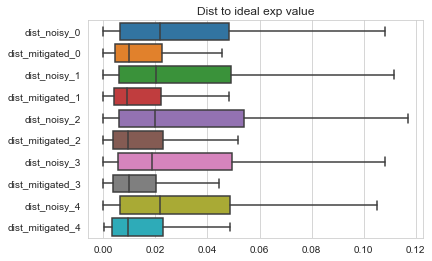

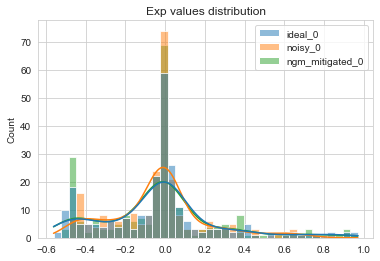

In [17]:
distances = []

num_spins = 5

for batch_X, batch_y in test_loader:
    out = []
    for q, model in enumerate(rfr_tree_list):
        out.append(model.predict(batch_X[:, :]))
    out = np.array(out).transpose()

    for ideal, noisy, ngm_mitigated in zip(
        batch_y.tolist(),
        batch_X[:, -5:].tolist(),
        out.tolist()
    ):
        for q in range(5):
            ideal_q = ideal[q]
            noisy_q = noisy[q]
            ngm_mitigated_q = ngm_mitigated[q]
            distances.append({
                f"ideal_{q}": ideal_q,
                f"noisy_{q}": noisy_q,
                f"ngm_mitigated_{q}": ngm_mitigated_q,
                f"dist_noisy_{q}": np.abs(ideal_q - noisy_q),
                f"dist_mitigated_{q}": np.abs(ideal_q - ngm_mitigated_q),
                f"dist_sq_noisy_{q}": np.square(ideal_q - noisy_q),
                f"dist_sq_mitigated_{q}": np.square(ideal_q - ngm_mitigated_q),
            })

plt.style.use({'figure.facecolor':'white'})

df = pd.DataFrame(distances)

for q in range(5):
    print(f'RMSE_noisy_{q}:', np.sqrt(df[f"dist_sq_noisy_{q}"].mean()))
    print(f'RMSE_mitigated_{q}:', np.sqrt(df[f"dist_sq_mitigated_{q}"].mean()))

print(f'RMSE_noisy:', np.sqrt(np.mean([df[f"dist_sq_noisy_{q}"].mean() for q in range(4)])))
print(f'RMSE_mitigated:', np.sqrt(np.mean([df[f"dist_sq_mitigated_{q}"].mean() for q in range(4)])))

sns.boxplot(data=df[["dist_noisy_0", "dist_mitigated_0", "dist_noisy_1", "dist_mitigated_1", "dist_noisy_2", "dist_mitigated_2", "dist_noisy_3", "dist_mitigated_3", "dist_noisy_4", "dist_mitigated_4"]], orient="h", showfliers = False)
plt.title("Dist to ideal exp value")
plt.show()

sns.histplot([df['ideal_0'], df['noisy_0'], df["ngm_mitigated_0"]], kde=True, bins=40)
plt.title("Exp values distribution")
plt.show()

In [18]:
with open('./model/mimic_zne_hardware/100q_twirl_rfr_list.pk', 'wb') as f:
    pickle.dump(rfr_tree_list, f)

In [19]:
num_circ_per_step = 50
k = train_test_split = 25
test_circuits = []
test_zne_vals = []
test_noisy_vals = []
test_Js = []
for start_each_step in list(range(len(circuits))[::num_circ_per_step]):
    test_circuits += circuits[start_each_step+k:start_each_step+num_circ_per_step]
    test_zne_vals += zne_mitigated_vals[start_each_step+k:start_each_step+num_circ_per_step]
    test_noisy_vals += noisy_vals[start_each_step+k:start_each_step+num_circ_per_step]
    test_Js += Js[start_each_step+k:start_each_step+num_circ_per_step]

In [20]:
to_df = []
steps = np.repeat(np.arange(1, 11), num_circ_per_step-train_test_split)

models = []
with open('./model/mimic_zne_hardware/100q_twirl_rfr_list.pk', 'rb') as f:
    model = pickle.load(f)
models.append((model, 'rfr_list'))

for i, (circ_trans, noisy_exp_val, zne_mitigated, step, J) in tqdm(enumerate(zip(test_circuits, test_noisy_vals, test_zne_vals, steps, test_Js)), total=len(test_noisy_vals)):
    row = dict()
    row['noisy'] = noisy_exp_val
    row['zne_mitigated'] = zne_mitigated
    row['step'] = step
    row['J'] = J

    X, _ = encode_data_v2_ecr([circ_trans], [zne_mitigated], [noisy_exp_val], obs_size=5)

    for j, (model, name) in enumerate(models):
        if name == 'mlp':
            row[name] = model(X).tolist()[0]
        elif name == 'gnn':
            row[name] = model(entry.noisy_0,
                                    entry.observable,
                                    entry.circuit_depth,
                                    entry.x,
                                    entry.edge_index,
                                    entry.batch).tolist()[0]
        elif name in ['ols_full', 'rfr_full']:
            row[name] = model.predict(X).tolist()[0]
        elif name in ['ols', 'rfr']:
            row[name] = model.predict(X[:, -5:]).tolist()[0]
        elif name in ['rfr_list']:
            row[name] = []
            for q, m in enumerate(model):
                row[name].append(m.predict(X))
            row[name] = np.array(row[name]).transpose()[0]
        elif name in ['zne']:
            row[name] = zne_mitigated
        else:
            raise NotImplementedError

    to_df.append(row)

df = pd.DataFrame(to_df)

  0%|          | 0/250 [00:00<?, ?it/s]

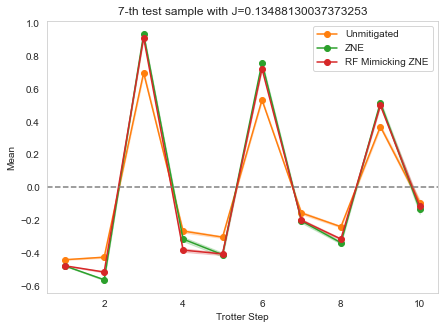

In [21]:
k = 7
new_df = pd.DataFrame(to_df).iloc[k::num_circ_per_step-train_test_split]

import warnings
warnings.filterwarnings('ignore')

for col in new_df.columns:
    if col not in ['step']:
        new_df[f'mean_{col}'] = new_df[col].apply(np.mean)
        new_df[f'ste_{col}'] = new_df[col].apply(np.std) / np.sqrt(num_circ_per_step-train_test_split)

plt.style.use({'figure.facecolor':'white'})
plt.figure(figsize=(7, 5))
steps = sorted(set(new_df.step))
legend_labels = ['Unmitigated', 'ZNE', 'RF Mimicking ZNE']

for i, col in enumerate(['mean_noisy', 'mean_zne_mitigated', 'mean_rfr_list']):
    plt.plot(steps, new_df[col], label=legend_labels[i], marker='o', color=f'C{i+1}')
    plt.fill_between(x=steps, y1=new_df[col]-new_df['ste_'+'_'.join(col.split('_')[1:])], y2=new_df[col]+new_df['ste_'+'_'.join(col.split('_')[1:])], alpha=0.2, color=f'C{i+1}')
plt.title(f'{k}-th test sample with J={test_Js[k]}')
plt.xlabel('Trotter Step')
plt.ylabel(r'Mean')
xmin, xmax = plt.gca().get_xlim()
plt.xlim([xmin, xmax])
plt.hlines(y=0, xmin=xmin, xmax=xmax, color='gray', linestyles='dashed')
plt.legend()
plt.grid(None)
plt.show()

In [25]:
df = pd.DataFrame(to_df)
df.to_pickle('/Users/haoranliao/GitHub/blackwater/docs/paper_figures/mimic_zne_hardware.pk')

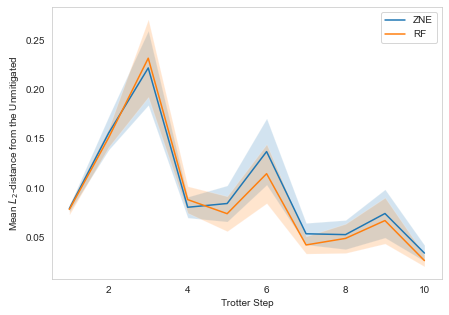

In [24]:
df = pd.DataFrame(to_df)
new_df = df
# new_df = df.iloc[[i for range_start in range(0, len(df), 60) for i in range(range_start+30, range_start+60)]]
# new_df = df.iloc[[i for range_start in range(30, len(df), 60) for i in range(range_start, range_start+30)]]

import warnings
warnings.filterwarnings('ignore')

def l2_dist(list1, list2):
    return np.sqrt(np.sum([(a - b)**2 for a, b in zip(list1, list2)]))

for col in new_df.columns:
    if col not in ['step', 'noisy', 'J']:
        new_df[f'L2_{col}'] = new_df.apply(lambda row: l2_dist(row['noisy'], row[col]), axis=1)

new_df_mean = new_df.groupby('step').agg('mean')
new_df_ste = new_df.groupby('step').agg('std') / np.sqrt(num_circ_per_step-train_test_split)

plt.style.use({'figure.facecolor':'white'})
plt.figure(figsize=(7, 5))
steps = sorted(set(new_df.step))
legend_labels = ['ZNE', 'RF']
for i, col in enumerate(['L2_zne_mitigated', 'L2_rfr_list']):
    plt.plot(steps, new_df_mean[col], label=legend_labels[i])
    plt.fill_between(x=steps, y1=new_df_mean[col]-new_df_ste[col], y2=new_df_mean[col]+new_df_ste[col], alpha=0.2)
plt.xlabel('Trotter Step')
plt.ylabel(r'Mean $L_2$-distance from the Unmitigated')
plt.legend()
plt.grid(None)
plt.show()